In [82]:
#pip install opencv-python


In [132]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [245]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import cv2
import re
import xml.etree.ElementTree as ET

from collections import defaultdict
import itertools
from collections import Counter 

import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [158]:
directory = 'data\\ecgen-radiology'

In [159]:
# extracting data from the xml documents
img = []
img_impression = []
img_finding = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".xml"):
        f = directory + '/' + filename
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'FINDINGS':
                                        finding=name.text
                                        
        for p_image in root.findall('parentImage'):
            
            img.append(p_image.get('id'))
            img_finding.append(finding)

  0%|          | 0/3955 [00:00<?, ?it/s]

100%|██████████| 3955/3955 [00:02<00:00, 1605.38it/s]


In [160]:
df = pd.DataFrame()
df['Image_path'] = img
df['Finding'] = img_finding

In [161]:
df.head()

,Image_path,Finding
0,CXR1_1_IM-0001-3001,The cardiac silhouette and mediastinum size ar...
1,CXR1_1_IM-0001-4001,The cardiac silhouette and mediastinum size ar...
2,CXR10_IM-0002-1001,The cardiomediastinal silhouette is within nor...
3,CXR10_IM-0002-2001,The cardiomediastinal silhouette is within nor...
4,CXR100_IM-0002-1001,Both lungs are clear and expanded. Heart and m...


In [162]:
df.shape

(7470, 2)

In [163]:
# def absolute_path(x):
#     '''Makes the path absolute '''
#     x = 'Scanned Images/'+ x + '.png'
#     return x

In [164]:
#df['Image_path'] = df['Image_path'].apply(lambda x : absolute_path(x)) # making the paths absolute

In [165]:
df.head()

,Image_path,Finding
0,CXR1_1_IM-0001-3001,The cardiac silhouette and mediastinum size ar...
1,CXR1_1_IM-0001-4001,The cardiac silhouette and mediastinum size ar...
2,CXR10_IM-0002-1001,The cardiomediastinal silhouette is within nor...
3,CXR10_IM-0002-2001,The cardiomediastinal silhouette is within nor...
4,CXR100_IM-0002-1001,Both lungs are clear and expanded. Heart and m...


In [166]:
image_dir = 'data\\NLMCXR_png'

In [167]:
# Initialize lists for images and labels
images = []
labels = []

# Load and preprocess images
for idx, row in df.iterrows():
    img_path = os.path.join(image_dir, row['Image_path'] + '.png')
    img = image.load_img(img_path, target_size=(128, 128))  # Resize as per your model's requirement
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize image
    images.append(img_array)
    labels.append(row['Finding'])

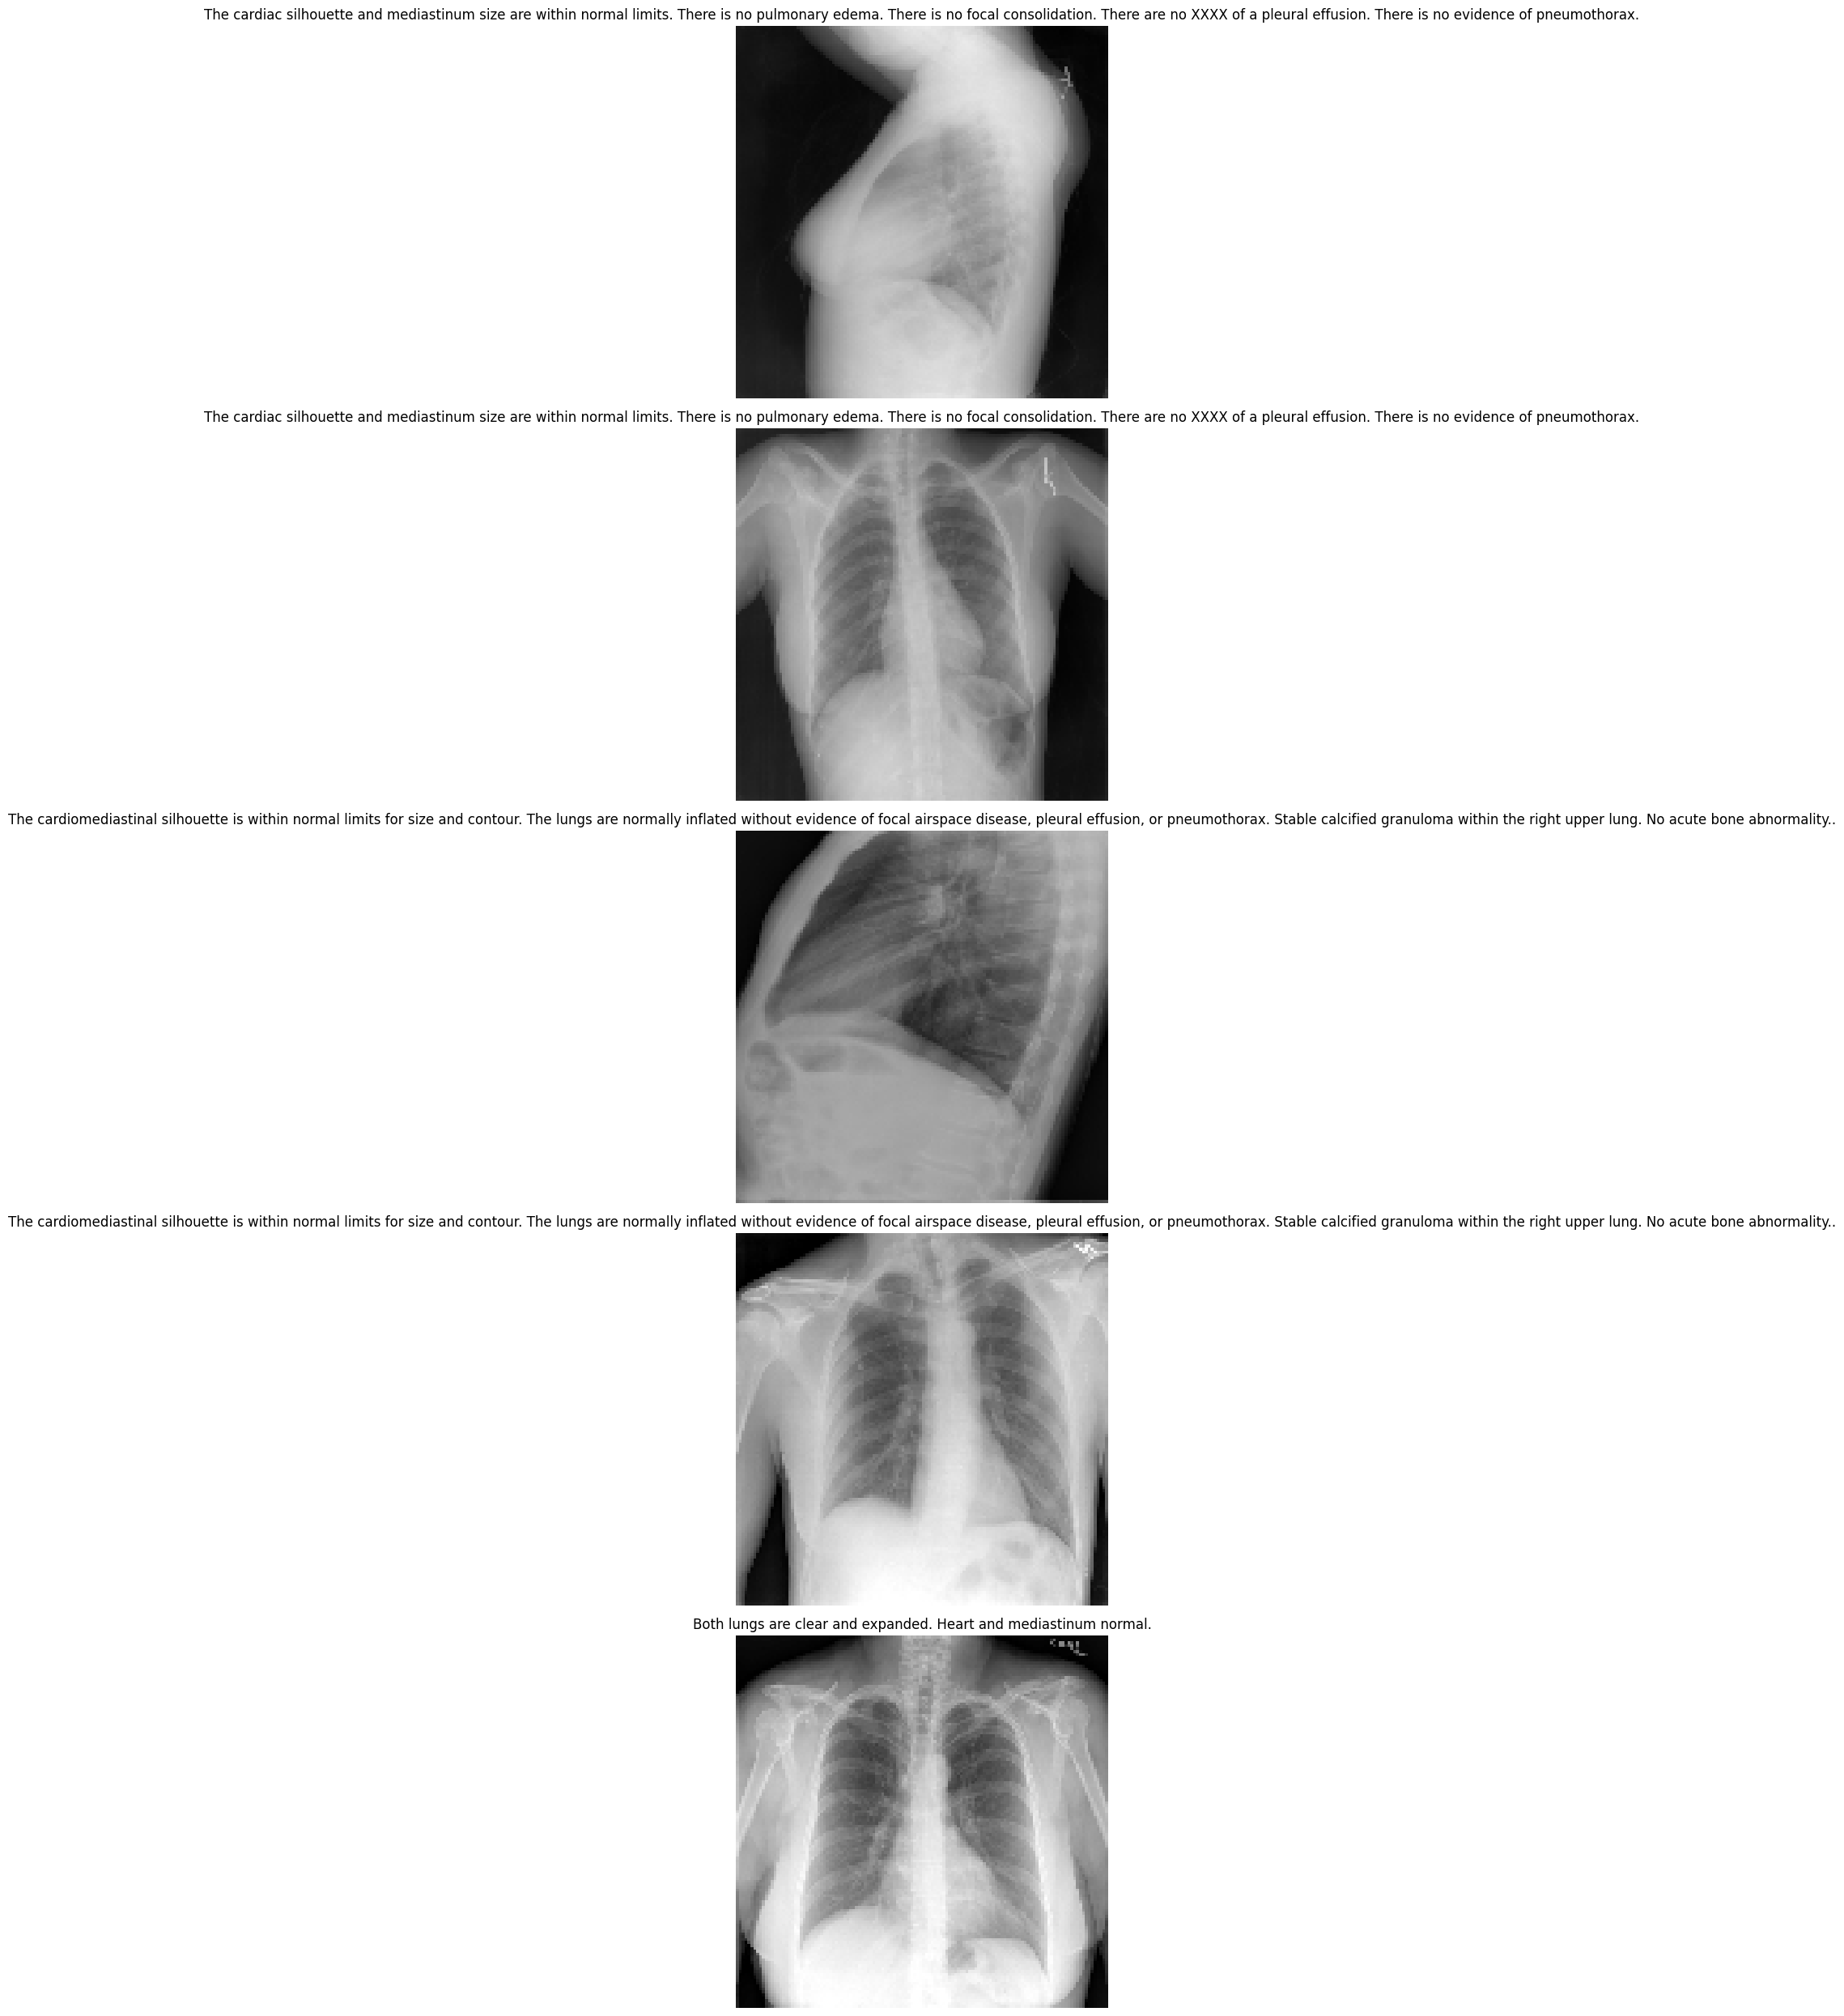

In [168]:
#visualizing the first 5 images along with their findings

fig, axes = plt.subplots(5, 1, figsize=(10, 25))

axes = axes.flatten()

for i in range(5):
    img_path = os.path.join(image_dir, df.iloc[i]['Image_path'] + '.png')
    img = image.load_img(img_path, target_size=(128, 128))  # Resize to match your model's input size
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(df.iloc[i]['Finding'])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [171]:
df['Finding'][0]    

'The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.'

### Text Cleaning

In [212]:
# lowercase
def lowercase(text):
    new_text = []
    for line in text:
        new_text.append(line.lower())
    return new_text

# Decontractions
def decontractions(text):
    '''Performs decontractions in the doc'''
    new_text = []
    for phrase in text:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase)
        new_text.append(phrase)
    
    return new_text

# removing puntuations
def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()-[]{;,:'\">/}?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations: 
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_numbers(text):
    '''Removes numbers and irrelevant text like xxxx*'''
    new_text = []
    for line in text:
        temp = re.sub(r"x*",'',line)
        new_text.append(re.sub(r'\d','',temp))
    return new_text

def words_filter(text):
    '''Removes words less than 2 characters except no and ct'''
    new_text = []
    for line in text:
        temp = line.split()
        temp2 = []
        for word in temp:
            if  len(word) <=2 and word != 'no' and word != 'ct':
                continue
            else:
                temp2.append(word)
        new_text.append(' '.join(e for e in temp2))
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r"\.\.+", '.', line))
    return new_text


def fullstops(text):
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.', ' .', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

In [213]:
def text_preprocessing(text):
    '''Combine all the preprocess functions'''
    new_text = lowercase(text)
    new_text = decontractions(new_text)
    new_text = rem_punctuations(new_text)
    new_text = rem_numbers(new_text)
    new_text = words_filter(new_text)
    new_text = multiple_fullstops(new_text)
    new_text = fullstops(new_text)
    new_text = multiple_spaces(new_text)
    new_text = separting_startg_words(new_text)
    new_text = rem_apostrophes(new_text)
    return new_text

In [214]:
df1 = df.copy()

In [215]:
df1['Finding'] = df1['Finding'].astype(str)

In [216]:
df1['Finding'] = text_preprocessing(df1['Finding'])

In [217]:
df1['Finding']

0       the cardiac silhouette and mediastinum size ar...
1       the cardiac silhouette and mediastinum size ar...
2       the cardiomediastinal silhouette within normal...
3       the cardiomediastinal silhouette within normal...
4       both lungs are clear and epanded .  heart and ...
                              ...                        
7465    cardiomediastinal silhouette demonstrates norm...
7466    cardiomediastinal silhouette demonstrates norm...
7467    lungs are clear bilaterally .  there no focal ...
7468    lungs are clear bilaterally .  there no focal ...
7469    lungs are clear bilaterally .  there no focal ...
Name: Finding, Length: 7470, dtype: object

In [218]:
#number of words in each findings
l = [len(report.split()) for report in df1['Finding'].values]

In [219]:
#maximum length of findings
max(l)

153

In [223]:
# plt.title('Number of Words per Report')
# sns.scatterplot(range(df1.shape[0]), l)
# plt.ylabel('Number of words')

In [238]:
l = []
for i in df1['Finding'].values:
    l.extend(i.split())

In [240]:
c = Counter(l)

words = []
count = []
for k,v in c.items():
    words.append(k)
    count.append(v)
words_count = list(zip(count, words))    

In [241]:
top_50_words = sorted(words_count)[::-1][:50]
bottom_50_words = sorted(words_count)[:50]

([<matplotlib.axis.XTick at 0x27a51d0b770>,
 [Text(0, 0, '.'),
  Text(1, 0, 'the'),
  Text(2, 0, 'no'),
  Text(3, 0, 'are'),
  Text(4, 0, 'normal'),
  Text(5, 0, 'and'),
  Text(6, 0, 'pleural'),
  Text(7, 0, 'pneumothora'),
  Text(8, 0, 'there'),
  Text(9, 0, 'effusion'),
  Text(10, 0, 'heart'),
  Text(11, 0, 'lungs'),
  Text(12, 0, 'size'),
  Text(13, 0, 'focal'),
  Text(14, 0, 'within'),
  Text(15, 0, 'clear'),
  Text(16, 0, 'limits'),
  Text(17, 0, 'pulmonary'),
  Text(18, 0, 'consolidation'),
  Text(19, 0, 'silhouette'),
  Text(20, 0, 'right'),
  Text(21, 0, 'mediastinal'),
  Text(22, 0, 'airspace'),
  Text(23, 0, 'cardiomediastinal'),
  Text(24, 0, 'left'),
  Text(25, 0, 'acute'),
  Text(26, 0, 'lung'),
  Text(27, 0, 'with'),
  Text(28, 0, 'disease'),
  Text(29, 0, 'stable'),
  Text(30, 0, 'unremarkable'),
  Text(31, 0, 'changes'),
  Text(32, 0, 'spine'),
  Text(33, 0, 'mediastinum'),
  Text(34, 0, 'structures'),
  Text(35, 0, 'contours'),
  Text(36, 0, 'thoracic'),
  Text(37, 0, 

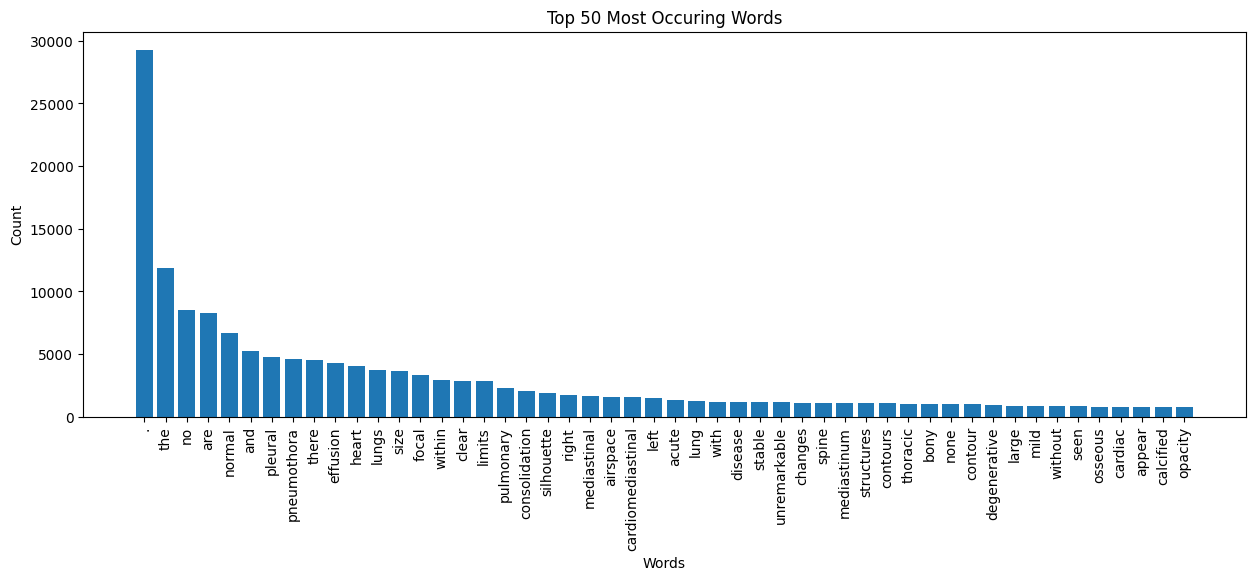

In [242]:
plt.figure(figsize=(15,5))
plt.bar(range(50), [c for c,w in top_50_words])
plt.title('Top 50 Most Occuring Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(ticks=range(50), labels=[w for c,w in top_50_words], rotation=90)

([<matplotlib.axis.XTick at 0x27a51813980>,
 [Text(0, 0, '<heart'),
  Text(1, 0, 'balloon'),
  Text(2, 0, 'beneath'),
  Text(3, 0, 'bipolar'),
  Text(4, 0, 'biventricular'),
  Text(5, 0, 'bronchiectatic'),
  Text(6, 0, 'cardiothoracic'),
  Text(7, 0, 'cartilage'),
  Text(8, 0, 'cervicothoracic'),
  Text(9, 0, 'completely'),
  Text(10, 0, 'component'),
  Text(11, 0, 'contributes'),
  Text(12, 0, 'difficult'),
  Text(13, 0, 'duct'),
  Text(14, 0, 'electrodes'),
  Text(15, 0, 'especially'),
  Text(16, 0, 'evolving'),
  Text(17, 0, 'favoring'),
  Text(18, 0, 'focally'),
  Text(19, 0, 'globular'),
  Text(20, 0, 'hips'),
  Text(21, 0, 'icdpacemaker'),
  Text(22, 0, 'impacted'),
  Text(23, 0, 'in'),
  Text(24, 0, 'include'),
  Text(25, 0, 'indistinctness'),
  Text(26, 0, 'making'),
  Text(27, 0, 'malignancy'),
  Text(28, 0, 'midshaft'),
  Text(29, 0, 'mostly'),
  Text(30, 0, 'nondilated'),
  Text(31, 0, 'observed'),
  Text(32, 0, 'once'),
  Text(33, 0, 'orthopedic'),
  Text(34, 0, 'osteophyti

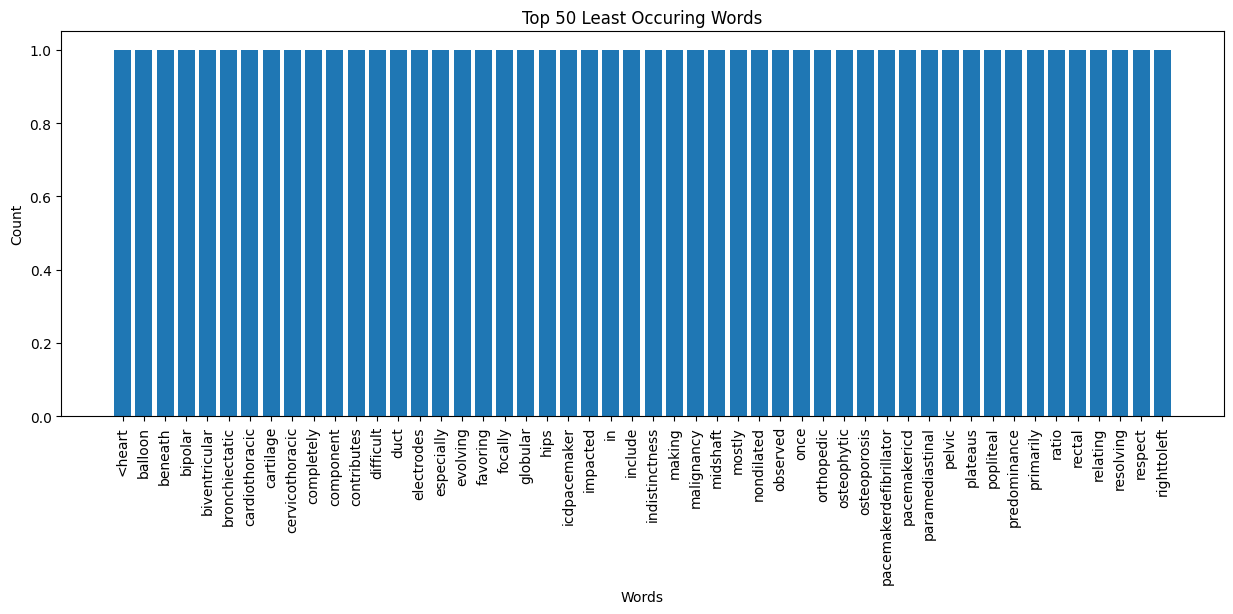

In [243]:
plt.figure(figsize=(15,5))
plt.bar(range(50), [c for c,w in bottom_50_words])
plt.title('Top 50 Least Occuring Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(ticks=range(50), labels=[w for c,w in bottom_50_words], rotation=90)

In [246]:
w = WordCloud(height=1500, width=1500).generate(str(l))

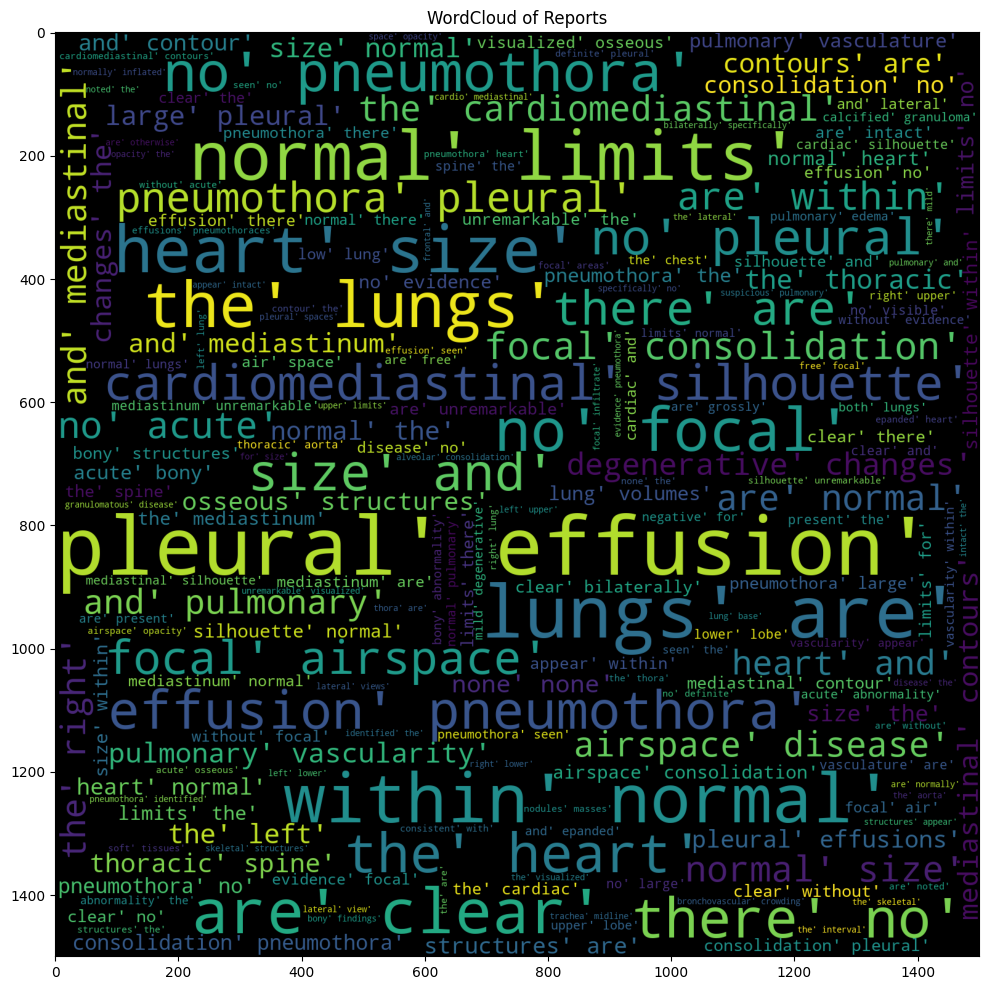

In [247]:
plt.figure(figsize=(12,12))
plt.title('WordCloud of Reports')
plt.imshow(w)

In [248]:
def remodelling(x):
    '''adds start and end tokens to a sentence '''
    return 'startseq' + ' ' + x + ' ' + 'endseq'

In [249]:
df1['Finding'] = df1['Finding'].apply(lambda x : remodelling(x))

In [ ]:
#df['Image_path'] = df['Image_path'].apply(lambda x : absolute_path(x)) # making the paths absolute

In [250]:
df1['Finding'][:10]

0    startseq the cardiac silhouette and mediastinu...
1    startseq the cardiac silhouette and mediastinu...
2    startseq the cardiomediastinal silhouette with...
3    startseq the cardiomediastinal silhouette with...
4    startseq both lungs are clear and epanded .  h...
5    startseq both lungs are clear and epanded .  h...
6    startseq there increased opacity within the ri...
7    startseq there increased opacity within the ri...
8    startseq there increased opacity within the ri...
9    startseq interstitial markings are diffusely p...
Name: Finding, dtype: object